# TEAM 44 - Lab 02 - Non-supervised learning
## Part 1: Content-based recommender system
## Part 2: SOM-based data visualization

Announcement: 29 November 2022

This is the second lab assignment of the course "Neural Networks and Intelligent Systems" at the National Technical University of Athens.

**Team 44** consists of **George Kyriakopoulos** (03118153) and **Serafeim Tzelepis** (03118849).

## Packages and imports

In [1]:
%pip install --upgrade pip
%pip install --upgrade nltk
%pip install --upgrade numpy
%pip install --upgrade joblib
%pip install --upgrade pandas
%pip install --upgrade somoclu
%pip install --upgrade scikit-learn
%pip install -U gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [2]:
import re
import nltk
import joblib
import somoclu
import matplotlib
import gensim.downloader

import pandas as pd
import numpy as np
import scipy as sp

from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [3]:
dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t', header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [4]:
team_seed_number = 44

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

my_index = df_data_2.iloc[team_seed_number,:].values

# movie titles (string)
titles = df_data_1.iloc[:, [2]].values[my_index]

# movie categories (string)
categories = df_data_1.iloc[:, [3]].values[my_index]
bins = df_data_1.iloc[:, [4]]

# movie categories in binary form (1 feature per category)
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index]

# movie summaries (string)
summaries =  df_data_1.iloc[:, [5]].values[my_index]

# list form of summaries
corpus = summaries[:,0].tolist()

# dataframe version of corpus
corpus_df = pd.DataFrame(corpus)

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [5]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['A Cage of Nightingales']
['"Music",  "Drama"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [6]:
print(corpus[1024])

This film is the story of Theo , the "Bad Boy of Bowling", suspended from the pro-tour for bashing an opponent in the head on national TV. Desperate to circumvent the 100-year suspension and get back into the game, Theo seeks out his estranged father Buzz, a man of legendary power in the bowling world - a man he has never met. But Buzz has turned to the dark side of the sport and runs an illegal dwarf bowling operation with his nefarious partner Miles Kastle. "And nobody sticks a finger into a bowling ball in this town without Miles Kastle knowing about it." Kastle's pyromaniac daughter Sheila  has the hots for Theo. Her psychotic brother Junior has just broken out of a mental institution and wants to murder Buzz. Kastle offers to get Theo back in the pins - for a price, and Theo finds himself faced with one of the impossible 7-10 splits of life.


After analyzing many of the movie descriptions, we found that the most common problems were:
- There are many film related words such as "film", "cinema", "story" and so on
- There are names used in the descriptions, which do not add any value to the description
- There are many stopwords
- There are many special characters and punctuation marks
- There is a need for lowercase conversion
- There is a need for Lemmatization

So we decided to remove all the stopwords, all the special characters and punctuation marks, all the film related words and all the names. We also decided to convert all the words to lowercase.

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('rslp')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/george/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/george/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/george/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package rslp to /home/george/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to /home/george/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
nltk_stopwords = stopwords.words('english')
extra_stopwords = ["film", "movie", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "first", "second", "third", "fourth", "fifth", "sixth", "seventh", "eighth", "ninth", "tenth", "story", "character", "plot", "time", "way", "scene"]

# import names_stopwords from names.txt (https://www.usna.edu/Users/cs/roche/courses/s15si335/proj1/files.php%3Ff=names.txt.html)
names_stopwords = []
with open('resources/names.txt', 'r') as f:
    for line in f:
        names_stopwords.append(line.strip())

# making sure there are no duplicates
names_stopwords = list(set(names_stopwords))

total_stopwords = nltk_stopwords + extra_stopwords + names_stopwords

print(len(total_stopwords))

18446


In [9]:
def preprocess_text(text):
    # tokenize
    tokens = word_tokenize(text)

    # remove stopwords
    tokens = [w for w in tokens if not w in total_stopwords]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # join tokens
    text = ' '.join(tokens)

    # lowercase
    text = text.lower()

    # remove punctuation marks and numbers using re
    text = re.sub(r'[^\w\s]', '', text)

    # remove extra spaces
    text = ' '.join(text.split())

    # remove url links using re
    text = re.sub(r'http\S+', '', text)
    return text

# preprocessed_corpus = [preprocess_text(text) for text in corpus]
# joblib.dump(preprocessed_corpus, 'resources/preprocessed_corpus.pkl')

preprocessed_corpus = joblib.load('resources/preprocessed_corpus.pkl')

print(f"- Original corpus: \n{corpus[3520]}")
print(f"- Preprocessed corpus: \n{preprocess_text(corpus[3520])}")

- Original corpus: 
Prior to the attack on Pearl Harbor, the U.S. Army buys some horses from the Range Busters' ranch for service in the Philippines. The cowboys tangle with Axis spies in both Texas and in the Philippines.
- Preprocessed corpus: 
prior attack harbor us army buy horse range busters ranch service philippines the cowboy tangle axis spy philippines


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [10]:
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_plain = vectorizer.transform(preprocessed_corpus)

print(corpus_tf_idf_plain.shape)

(5000, 45835)


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [11]:
def content_recommender(target_movie, max_recommendations, corpus_type):
    dist = np.zeros(corpus_type.shape[0])
    for i in range(dist.shape[0]):
        dist[i] = sp.spatial.distance.cosine(corpus_type[target_movie].toarray()[0], corpus_type[i].toarray()[0])

    dist_sorted = np.argsort(dist)
    dist_sorted = dist_sorted[1:max_recommendations+1]

    print("- Target movie:")
    print(titles[target_movie][0])
    print(categories[target_movie][0].replace('"', ''))
    print(corpus[target_movie])
    print("--------------------------------------------------")
    
    for i in range(len(dist_sorted)):
        print(f"- Recommended movie {i+1}:")
        print(titles[dist_sorted[i]][0])
        print(categories[dist_sorted[i]][0].replace('"', ''))
        print(corpus[dist_sorted[i]])
        if i != len(dist_sorted)-1:
            print("--------------------------------------------------")

In [12]:
content_recommender(19, 3, corpus_tf_idf_plain)

- Target movie:
Feast of Love
Drama,  Romantic drama,  Romance Film,  Ensemble Film,  Film adaptation
The movie deals with love and its various incarnations, set within a community of friends in Portland, Oregon. Harry Stevenson  narrates about how love can affect one's life.  Bradley run a small cafe in Portland. He has been married to his wife Kathryn for some time. However, their marriage becomes strained. Soon enough Kathryn begins a lesbian relationship with a woman, Jenny, she meets playing softball and leaves Bradley. The divorce affects Bradley greatly, but he soon finds love again in Diana, a realtor who also has a past with a married man named David. Though she ends her affair with David to marry Bradley they ultimately declare they are in love with each other and Diana leaves Bradley, again devastating him. Now twice divorced Bradley suffers a mini-breakdown and stabs himself in the hand. As he is getting stitched up in the hospital he falls for his doctor, Margaret. In the 

We observe that for ID = 19 the recommendations are very good, as all the film are romance related dramas.

In [13]:
content_recommender(51, 3, corpus_tf_idf_plain)

- Target movie:
72 Tenants of Prosperity
Romantic comedy,  Family Drama,  Comedy-drama,  Comedy,  Chinese Movies
In 1970s Hong Kong, rapacious landlords try to evict 72 tenants but sworn brothers Ha Kung and Shek Kin help the group of 72 defeat the landlord and landlady and coincidentally rescue Pinky from a planned forced marriage. When both sworn brothers fall for Pinky and propose to her, she flips a coin heads or tails, they both cheated during the toss but Ha wins her hand in marriage. The sworn brothers become sworn enemies and Sheks hatred fuels intense rivalry against Ha in business dealings ranging from the manufacture of plastic flowers to the selling of stinky bean curd. Even after 40 years they continue to clash and in 2010 they are in keen competition selling electronics appliances in Sai Yeung Choi Street, Mongkok, the busiest street in the city and still home to the 72 tenants. In fiercely competitive Sai Yeung Choi Street high rents force businessmen to use every means 

For ID = 51 the recommendations aren't good, while the target movie is romantic comedy, there is thriller movie as a recommendation.

In [14]:
content_recommender(46, 3, corpus_tf_idf_plain)

- Target movie:
The Messengers
Thriller,  Drama,  Horror
A mother tells her son he has to be strong and that everything will be okay. As she packs a suitcase, she hears something coming towards the door and makes her son hide under the bed. The door bursts open and something throws the woman against the wall. The son, terrified, runs out of the room and into his equally scared sister. She grabs him and runs down the stairs. The boy hides under a table, but his sister is caught and pushed over the stair railings and is obviously injured. She crawls to the boy and tells him to run, but is dragged to the cellar, her nails clawing the floor. The boy runs into the kitchen and hides in a cabinet. It is dark except for a sliver of light down his face. The cabinet door opens and a hand yanks him out. Five years later, the Solomon family from Chicago move into the house, hoping to start a sunflower farm. The teenaged daughter, Jess, is upset about moving away from her friends. She had once driv

For ID = 46 the recommendations are good, as all the films are in the genre of horror, thriller, drama.

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 





Now we are trying to optimize the TfidfVectorizer. We tweak the max_df and min_df parameters in order to achieve a better recommender system.

In [15]:
# optimize TfIdfVectorizer
vectorizer = TfidfVectorizer(max_df=0.8, min_df=20, stop_words=total_stopwords)
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf = vectorizer.transform(preprocessed_corpus)

print(corpus_tf_idf.shape)

/home/george/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aadil', 'aaisha', 'aakash', 'aaliyah', 'aamanda', 'aamil', 'aamir', 'aaran', 'aaren', 'aarica', 'aarik', 'aarika', 'aarin', 'aarion', 'aarn', 'aaron', 'aarron', 'aarthi', 'aarti', 'aaryn', 'abagail', 'abayomi', 'abbagail', 'abbas', 'abbe', 'abbey', 'abbi', 'abbie', 'abbigail', 'abbigale', 'abbra', 'abby', 'abbye', 'abdallah', 'abdel', 'abdiel', 'abdul', 'abdulaziz', 'abdulla', 'abdullah', 'abdullatif', 'abdulrahman', 'abe', 'abeer', 'abel', 'abelardo', 'abelina', 'abelino', 'abena', 'abhishek', 'abi', 'abie', 'abiel', 'abigael', 'abigail', 'abigal', 'abigale', 'abigayle', 'abimael', 'abner', 'abra', 'abraham', 'abrahan', 'abrahim', 'abrahm', 'abram', 'abran', 'abrianna', 'abril', 'abrina', 'absalon', 'abu', 'abubakar', 'acacia', 'ace', 'acey', 'achary', 'achilles', 'ada', 'adah', '

(5000, 4279)


In [16]:
content_recommender(46, 7, corpus_tf_idf)

- Target movie:
The Messengers
Thriller,  Drama,  Horror
A mother tells her son he has to be strong and that everything will be okay. As she packs a suitcase, she hears something coming towards the door and makes her son hide under the bed. The door bursts open and something throws the woman against the wall. The son, terrified, runs out of the room and into his equally scared sister. She grabs him and runs down the stairs. The boy hides under a table, but his sister is caught and pushed over the stair railings and is obviously injured. She crawls to the boy and tells him to run, but is dragged to the cellar, her nails clawing the floor. The boy runs into the kitchen and hides in a cabinet. It is dark except for a sliver of light down his face. The cabinet door opens and a hand yanks him out. Five years later, the Solomon family from Chicago move into the house, hoping to start a sunflower farm. The teenaged daughter, Jess, is upset about moving away from her friends. She had once driv

We notice that with the appropiate tuning of the parameters we can achieve a better recommender system. We can see that the 7 recommendations for ID = 46 are all horror or thriller movies, which is the genre of the target movie.

In [17]:
content_recommender(51, 7, corpus_tf_idf)

- Target movie:
72 Tenants of Prosperity
Romantic comedy,  Family Drama,  Comedy-drama,  Comedy,  Chinese Movies
In 1970s Hong Kong, rapacious landlords try to evict 72 tenants but sworn brothers Ha Kung and Shek Kin help the group of 72 defeat the landlord and landlady and coincidentally rescue Pinky from a planned forced marriage. When both sworn brothers fall for Pinky and propose to her, she flips a coin heads or tails, they both cheated during the toss but Ha wins her hand in marriage. The sworn brothers become sworn enemies and Sheks hatred fuels intense rivalry against Ha in business dealings ranging from the manufacture of plastic flowers to the selling of stinky bean curd. Even after 40 years they continue to clash and in 2010 they are in keen competition selling electronics appliances in Sai Yeung Choi Street, Mongkok, the busiest street in the city and still home to the 72 tenants. In fiercely competitive Sai Yeung Choi Street high rents force businessmen to use every means 

For the ID = 51 we can see that the recommendations are better than previously where we had a thriller movie as a recommendation. Now all the movies are in the genre of drama or comedy which is the genre of the target movie.

In [18]:
content_recommender(19, 7, corpus_tf_idf)

- Target movie:
Feast of Love
Drama,  Romantic drama,  Romance Film,  Ensemble Film,  Film adaptation
The movie deals with love and its various incarnations, set within a community of friends in Portland, Oregon. Harry Stevenson  narrates about how love can affect one's life.  Bradley run a small cafe in Portland. He has been married to his wife Kathryn for some time. However, their marriage becomes strained. Soon enough Kathryn begins a lesbian relationship with a woman, Jenny, she meets playing softball and leaves Bradley. The divorce affects Bradley greatly, but he soon finds love again in Diana, a realtor who also has a past with a married man named David. Though she ends her affair with David to marry Bradley they ultimately declare they are in love with each other and Diana leaves Bradley, again devastating him. Now twice divorced Bradley suffers a mini-breakdown and stabs himself in the hand. As he is getting stitched up in the hospital he falls for his doctor, Margaret. In the 

At first sight according to the genre of the recommendations, its seems like the recommendations are less accurate, as there is a recommendation with a genre of thriller. However it is also a drama movie, and if we look at the plot of the movie we can see that the movie shares many commons with the target movie. So the recommendation for ID = 19 is also accurate.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [19]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

In [20]:
# model = gensim.downloader.load('word2vec-google-news-300')
# joblib.dump(model, 'resources/word2vec-google-news-300.pkl')

model = joblib.load('resources/word2vec-google-news-300.pkl')

In [21]:
# print some similar words to test the downloaded model.
print(model.most_similar('love'))
print(model.most_similar('murder'))
print(model.most_similar('explore'))

[('loved', 0.6907791495323181), ('adore', 0.6816874146461487), ('loves', 0.6618632674217224), ('passion', 0.6100709438323975), ('hate', 0.6003957390785217), ('loving', 0.5886635780334473), ('Ilove', 0.570294976234436), ('affection', 0.5664337873458862), ('undying_love', 0.5547305345535278), ('absolutely_adore', 0.5536840558052063)]
[('murders', 0.8213666081428528), ('slaying', 0.8206247687339783), ('murdering', 0.7666814923286438), ('slayings', 0.7325871586799622), ('muder', 0.7306681275367737), ('homicide', 0.7204719185829163), ('killings', 0.7011669278144836), ('murdered', 0.6957515478134155), ('attempted_murder', 0.6941132545471191), ('fatal_stabbing', 0.6720560789108276)]
[('exploring', 0.7604826092720032), ('explored', 0.6915038228034973), ('examine', 0.6361454129219055), ('Explore', 0.6147732138633728), ('Exploring', 0.6129143238067627), ('delve_deeper', 0.5519265532493591), ('delve', 0.551725447177887), ('discuss', 0.5484867095947266), ('explores', 0.5451818704605103), ('discove

#### Άλλα εμφυτεύματα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.

#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.

### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμοποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [22]:
def build_tfw2v(corpus, vectors, embeddings_size):
    corpus_tf_idf_new = vectorizer.transform(corpus)
    new_corp = np.zeros((len(corpus), embeddings_size))

    for i in range(len(corpus)):
        description = corpus[i]
        tokens = [w for w in word_tokenize(description)]
        dummy1 = np.zeros(embeddings_size)
        dummy2 = 0
        for word in tokens:
            if word in vectorizer.vocabulary_:
                index = vectorizer.vocabulary_[word]
            else: 
                continue

            tf_idf_value = corpus_tf_idf_new[i, index]
            
            if word in vectors.index_to_key:
                dummy1 += tf_idf_value * vectors[word]
                dummy2 += tf_idf_value
            else:
                continue
        
        new_corp[i,:] = dummy1/dummy2

    return new_corp

In [23]:
# tfw2v_corpus = build_tfw2v(preprocessed_corpus, vectors=model, embeddings_size=300)
# joblib.dump(tfw2v_corpus, 'resources/tfw2v_corpus.pkl')

tfw2v_corpus = joblib.load('resources/tfw2v_corpus.pkl')

In [24]:
content_recommender(19, 7, csr_matrix(tfw2v_corpus))

- Target movie:
Feast of Love
Drama,  Romantic drama,  Romance Film,  Ensemble Film,  Film adaptation
The movie deals with love and its various incarnations, set within a community of friends in Portland, Oregon. Harry Stevenson  narrates about how love can affect one's life.  Bradley run a small cafe in Portland. He has been married to his wife Kathryn for some time. However, their marriage becomes strained. Soon enough Kathryn begins a lesbian relationship with a woman, Jenny, she meets playing softball and leaves Bradley. The divorce affects Bradley greatly, but he soon finds love again in Diana, a realtor who also has a past with a married man named David. Though she ends her affair with David to marry Bradley they ultimately declare they are in love with each other and Diana leaves Bradley, again devastating him. Now twice divorced Bradley suffers a mini-breakdown and stabs himself in the hand. As he is getting stitched up in the hospital he falls for his doctor, Margaret. In the 

As we see our content_recommender is functional for the embeddings corpus as well. We can now use it to recommend movies based on the embeddings of the movie descriptions. The quality of the recommendations will be discussed in the next chapter.

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

#### Text Preprocessing

For the text preprocessing we used the following steps:
- We removed the stopwords from the text, including the stopwords from the nltk library, film related words like "movie" and "film" and names
- We used the WordNetLemmatizer from the nltk library to lemmatize the words, increasing the accuracy of the recommender
- We used a lowercase conversion for all words
- We removed the punctuation marks and numbers
- We removed extra spaces
- Finally, we removed words starting with 'http', which are basically links

#### TfidfVectorizer optimization

For the TfidVectorizer optimization, we tuned the max_df and min_df parameters and tried to determine which combination gave the best overall results in specific instances. We wanted to lower the dimensionality as well. The final values are max_df = 0.8 and min_df = 20. Based on these values, we actually removed the words that appeared in more than 80% of the documents and those that appeared in less than 20 documents. Therefore, we removed the words that are not very informative and we managed to lower the dimensionality.

Before we move to the results commentary, we will rewrite the content_recommender function, in order to be able to see the cosine similarity for each recommendation. This will help us evaluate the results and compare differend recommenders.

In [25]:
def content_recommender(target_movie, max_recommendations, corpus_type):
    dist = np.zeros(corpus_type.shape[0])
    for i in range(dist.shape[0]):
        dist[i] = sp.spatial.distance.cosine(corpus_type[target_movie].toarray()[0], corpus_type[i].toarray()[0])
    
    dist_sorted = np.argsort(dist)
    dist_sorted = dist_sorted[1:max_recommendations+1]

    print("- Target movie:")
    print(titles[target_movie][0])
    print(categories[target_movie][0].replace('"', ''))
    print(corpus[target_movie])
    print("--------------------------------------------------")

    for i in range(len(dist_sorted)):
        print(f"- Recommended movie {i+1}:")
        print(f"Similarity: {1-dist[dist_sorted[i]]}")
        print(titles[dist_sorted[i]][0])
        print(categories[dist_sorted[i]][0].replace('"', ''))
        print(corpus[dist_sorted[i]])
        if i != len(dist_sorted)-1:
            print("--------------------------------------------------")

#### Cherry-picking

In [26]:
content_recommender(10, 7, corpus_tf_idf)

- Target movie:
Nadiya Kollappetta Rathri
Mystery
Three murders happen on a moving train. Murder on the Orient Express, an Agatha Christie classic, inspired the crime thriller. Internationally famous Indian shooter Nadiya  catches Sauparnika Express, a train on its inaugural run between Chennai and Mangalore. She is murdered en route, is not the only victim on the train. A famous dancer, Thulasi and a television reporter, Shreya Mariya, are also killed. When investigators fail to solve the mystery, the case is turned over to Sharafuddeen Taramasi , IPS, an encounter specialist from the Railway Anti-Criminal Task Force.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.2396729054682436
Accused
Mystery
Two dance partners become embroiled in a murder mystery when one of the dancers is accused of murder.
--------------------------------------------------
- Recommended movie 2:
Similarity: 0.22480552500588924
Atomic Train
Disaster,  Action/Adventure,  A

For ID = 10 the recommendations are all films, related to train, most of them being mystery movies. This is a good result, since the target movie evolves around a murder case happened on a train.

In [27]:
content_recommender(46, 7, corpus_tf_idf)

- Target movie:
The Messengers
Thriller,  Drama,  Horror
A mother tells her son he has to be strong and that everything will be okay. As she packs a suitcase, she hears something coming towards the door and makes her son hide under the bed. The door bursts open and something throws the woman against the wall. The son, terrified, runs out of the room and into his equally scared sister. She grabs him and runs down the stairs. The boy hides under a table, but his sister is caught and pushed over the stair railings and is obviously injured. She crawls to the boy and tells him to run, but is dragged to the cellar, her nails clawing the floor. The boy runs into the kitchen and hides in a cabinet. It is dark except for a sliver of light down his face. The cabinet door opens and a hand yanks him out. Five years later, the Solomon family from Chicago move into the house, hoping to start a sunflower farm. The teenaged daughter, Jess, is upset about moving away from her friends. She had once driv

As noted for this ID in a previous question, for ID = 46 we can see that the 7 recommendations are all horror or thriller movies, which is the genre of the target movie.

In [28]:
content_recommender(20, 7, corpus_tf_idf)

- Target movie:
The Force
Thriller,  Drama
Cal Warner  is a rookie police officer who has frightening nightmares after his friend and fellow police officer, Des Flynn , is killed under suspicious circumstances: the soul of Des enters into the body of Cal in order to seek revenge for his murder. Cal is unaware of what is happening and needs the help of a psychiatrist when he starts exhibiting unusual behavior. These nightmares lead Cal to uncover evidence of corruption and even murder within the police department. Sarah Flynn  portrays the wife of the dead officer, Des.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.25963175349047307
Nariman
Crime Fiction,  Action,  Drama
The film portrays an aggressive and belligerent police officer named Nariman who investigates a murder case for which an innocent man is falsely accused.
--------------------------------------------------
- Recommended movie 2:
Similarity: 0.24541669652594145
End of Watch
Thrill

For ID = 20, all the recommendations are either thriller or drama which are the genres of the target movie. Also reading the movie descriptions we notice that all the movies are crime related.

In [29]:
content_recommender(16, 7, corpus_tf_idf)

- Target movie:
Session Man
Short Film,  Drama,  Indie,  Musical Drama
An aging, but capable and talented session guitarist named McQueen  is awakened by a late-night call from a nearby recording studio. He is needed to help smooth out some tracks that are being worked on by an established and popular hard rock band, the Raging Kings. The band’s own lead guitarist, Dean Storm  is resentful of McQueen’s involvement, and after an argument with the other members he decides to leave the group altogether. Impressed by McQueen’s skills, the band asks him on the spot to replace Storm and he graciously accepts, fulfilling his lifelong dream. After a brief jam session, Storm suddenly returns to the studio and asks to speak privately with the original band. They soon return from the meeting, and one member comes to McQueen and reluctantly tells him that he’s out. Stunned, McQueen manages to complete what he was called to do and returns home to his wife, who is still in bed. She asks what the cal

For ID = 16, we notice that the recommendations are quite accurate, as the target movie is a musical and all the recommended movies are musicals as well.

In [30]:
content_recommender(12, 7, corpus_tf_idf)

- Target movie:
In the Line of Duty 4: Witness
Action Thrillers,  World cinema,  Action/Adventure,  Martial Arts Film,  Action,  Chinese Movies
The film begins in Seattle. Seattle police officers Madam Yeung Lai-ching , Donnie Yen, and their Caucasian partner Peter Woods tail a group of Chinese cocaine dealers through a mall. Madam Yeung and Peter tail them to a seaport that night, where a shipment has just arrived from Hong Kong. Chinese workmen load crates into the drug dealers' truck. Madam Yeung, in defiance of Peter, acrobatically infiltrates the docks and enters the truck, but is caught by one of the workmen, Luk Wan-ting . She convinces him that she's a stowaway illegal immigrant from Hong Kong, and he takes her to his nearby attic apartment, where he gives her some money to help her, as he and his brother too were illegal immigrants for seven years. He has just obtained legal ID cards for both of them. She tries to stealthily check in with Peter, who is tailing the cocaine deal

For ID = 12, we notice that all the recommendations are very good being action or/and thriller movies, all of them crime related which is the case for the target movie as well.

#### Nit-picking

In [31]:
content_recommender(15, 7, corpus_tf_idf)

- Target movie:
Ganesha subramanya
Comedy
Ganesha and Subramanya, two brothers, promised their late father that they would remain bachelors until they achieve something significant in their lives. Their father thinks marriage would hinder personal achievements. Ganesha works at a construction firm, while younger brother Subramanya pursues fine arts. They shun female company, recoiling at the very sight of ladies. Much to their chagrin, they find themselves being sought by the fair sex much too often. Be it the girl residing in the house opposite to theirs or the middle aged lady house-owner, they always find themselves in situations that they think could shake their principles. Eventually, to be able to live in peace, they move out of their own house to a rented one, whose owner is obsessed with story-telling. Subramanya gets a chance to attended a specific fine arts course that he thinks would be useful to his career and has to go out of town. What happens to Ganesha in Subramanya's a

For ID = 15 our tf_idf based recommender is not accurate. The first recommended movie is a thriller while the target movie is a comedy.

In [32]:
content_recommender(23, 7, corpus_tf_idf)

- Target movie:
Uncorked
Romance Film
Johnny  is a high-powered executive who is definitely not looking to fall in love but a business conference takes her to wine country she meets a handsome widower Andrew  who invites Johnny to meet his family after she loses her job. In helping his parents' winery she begins to fall in love with him and his family but when she gets offered another job she has to choose between her career or Andrew.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.208534168450227
Kalisundam Raa
Family Film
Raghaviah  and Ram Mohan  are brothers-in-law. The two are at loggerheads because of a family feud. Raghavaiah is nearing his 60s and its time for his 'shastipoorti' ceremony. Upon incessant requests from his wife, Raghavaiah decides to invite  his daughter-in-law and grandsons who are staying in Bombay.http://www.idlebrain.com/movie/archive/mr-kalisundam.html Raghu  is the alienated, handsome grandson of Raghavaiah. After ar

For ID = 23 the recommendations are not good enough. The second recommended movie is a sports comedy, while the target movie is romance film.

In [33]:
content_recommender(18, 7, corpus_tf_idf)

- Target movie:
Tomka and His Friends
Family Film,  Drama
Tomka is a boy who likes playing football with his friends. When the German army captures his town, the German soldiers establish their camp in the town stadium. Tomka with help from his friends and their parents organizes sabotage actions against the soldiers.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.25791489957413605
The Crazies
Thriller,  Action/Adventure,  Science Fiction,  Horror,  Indie,  Doomsday film,  Cult,  Disaster,  B-movie,  Action
The film follows two stories, one about the civilians trying to stay alive during the disaster, having to battle both "the crazies" as well as U.S. soldiers ordered to shoot on sight. The other involves the political and military leaders trying to contain the epidemic. Set in the small town of Evans City, Pennsylvania, the central characters are firefighter David , his girlfriend, nurse Judy and firefighter Clank . David was a Green Beret and

For ID = 18 the recommender is way off. While the target movie is a family drama movie, the first recommended movie is a thriller horror movie.

In [34]:
content_recommender(37, 7, corpus_tf_idf)

- Target movie:
Trivial
Thriller,  Psychological thriller
Lt. Jacques Renard  is struggling with depression following the untimely death of his beloved wife, Chloé. After six months in a mental hospital following a suicide attempt, the disheveled and lonely Le Havre police lieutenant is still haunted by visions of his wife. One day, Renard finds a mysterious woman  waiting for him in his car. She implores him to visit the manager of the Hotel Normandy, Antoine Bérangère , in nearby Deauville in Room 401. She insists that only Renard can help her, and then leaves. Renard drives to Deauville to the luxury hotel where he meets Bérangère's thirty-nine year old son, Camille , and learns that Bérangère, who worked as manager of the Hotel Normandy for nearly four decades, vanished forty-eight hours earlier under suspicious circumstances. Without identification or money, he took his Mercedes, which he hadn't driven in years, and simply vanished, leaving everything behind except his hunting rif

For ID = 37 the recommender is not accurate. The target movie is a thriller, while there are 2 recommended movies that are romance movies.

In [35]:
content_recommender(48, 7, corpus_tf_idf)

- Target movie:
Compensation
Romance Film,  Drama
Inspired by a 1906 poem from early African American writer, Paul Laurence Dunbar, the unique drama explores aspects of Black culture in both turn of the century and present day Chicago in two parallel love stories, both about the relationship between a deaf woman and a hearing man. The narrative revolves about two couples, Malindy and Arthur, and Malaika and Nico, respectively taking place at the beginning and end of the twentieth century. Both pairs revel in the splendor or romance and a possible lifetime commitment only to be forced to deal with the dreaded disease of their difference times: tuberculosis and AIDS. The multi-layered film tackles various issues that arise in the relationship of the "mixed" couples.Compensation Press Release.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.15793735456379576
About Last Night
Romantic comedy,  Comedy-drama,  Drama,  Comedy,  Romantic drama,  Romance 

For ID = 48 the recommender is not accurate. The target movie is a romance drama film, and there is a recommendation of crime fiction thriller.

#### Advantages and disadvantages of tfidf based recommender system

##### Advantages
- Tfidf is very easy to calculate
- It can be easily used to find similarity between two documents
- With tfidf we can identify key terms in the document
- Its representation is faster calculated than Word2Vec

##### Disadvantages
- Tfidf does not take into account the context of the words
- Tfidf does not consider the semantics of words, so synonyms or related terms are not considered
- Tfidf can easily lead to very sparse feature vectors
- Tfidf based recommender systems are sensitive to changes in the dataset, as it is based on the frequency of the words in the dataset, so addition or removal of a document can lead to drastic changes

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


#### Word2Vec

In [36]:
content_recommender(16, 7, csr_matrix(tfw2v_corpus))

- Target movie:
Session Man
Short Film,  Drama,  Indie,  Musical Drama
An aging, but capable and talented session guitarist named McQueen  is awakened by a late-night call from a nearby recording studio. He is needed to help smooth out some tracks that are being worked on by an established and popular hard rock band, the Raging Kings. The band’s own lead guitarist, Dean Storm  is resentful of McQueen’s involvement, and after an argument with the other members he decides to leave the group altogether. Impressed by McQueen’s skills, the band asks him on the spot to replace Storm and he graciously accepts, fulfilling his lifelong dream. After a brief jam session, Storm suddenly returns to the studio and asks to speak privately with the original band. They soon return from the meeting, and one member comes to McQueen and reluctantly tells him that he’s out. Stunned, McQueen manages to complete what he was called to do and returns home to his wife, who is still in bed. She asks what the cal

For ID = 16 we notice that the recommendations are quite accurate, as the target movie is a musical and all the recommended movies are musical as well, except for one which is a comedy, but reading the description it's about a girl playing in a rock band so this movie is a good recommendation as well.

In [37]:
content_recommender(29, 7, csr_matrix(tfw2v_corpus))

- Target movie:
The Story of Joseph and His Brethren
Children's/Family,  Epic,  Hagiography,  Children's,  Drama,  Family Film
Joseph, son of Israel  and Rachel, lived in the land of Canaan with eleven brothers and one sister. He was Rachel's firstborn and Israel's eleventh son. Of all the sons, Joseph was loved by his father the most. Israel even arrayed Joseph with a "long coat of many colors".Another possible translation is "coat with long sleeves" - see "A Dictionary of the Targumim, Talmud Bavli, Talmud Yerushalmi and Midrashic Literature", 1903. ISBN 1-932443-20-7 Israel's favoritism toward Joseph caused his half brothers to hate him, and when Joseph was seventeen years old he had two dreams that made his brothers plot his demise. In the first dream, Joseph and his brothers gathered bundles of grain. Then, all of the grain bundles that had been prepared by the brothers gathered around Joseph's bundle and bowed down to it. In the second dream, the sun , the moon  and eleven stars 

For ID = 29 we notice that there is a recommendation thriller crime movie, while the target movie is children's/family movie

#### Word2Vec vs tfidf

In [38]:
content_recommender(20, 7, csr_matrix(tfw2v_corpus))

- Target movie:
The Force
Thriller,  Drama
Cal Warner  is a rookie police officer who has frightening nightmares after his friend and fellow police officer, Des Flynn , is killed under suspicious circumstances: the soul of Des enters into the body of Cal in order to seek revenge for his murder. Cal is unaware of what is happening and needs the help of a psychiatrist when he starts exhibiting unusual behavior. These nightmares lead Cal to uncover evidence of corruption and even murder within the police department. Sarah Flynn  portrays the wife of the dead officer, Des.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.8543494368363459
Jesse Stone: Innocents Lost
Crime Fiction,  Thriller,  Television movie,  Drama,  Film adaptation,  Crime Thriller
After being replaced as the chief of police in Paradise, Massachusetts by the town council president's son-in-law, William Butler , Jesse Stone is still without a full-time job . Nevertheless, he continue

For the ID = 20 we get different recommendations compared to tfidf, but they are all crime related movies, which is the case of the target movie.

In [39]:
content_recommender(15, 7, csr_matrix(tfw2v_corpus))

- Target movie:
Ganesha subramanya
Comedy
Ganesha and Subramanya, two brothers, promised their late father that they would remain bachelors until they achieve something significant in their lives. Their father thinks marriage would hinder personal achievements. Ganesha works at a construction firm, while younger brother Subramanya pursues fine arts. They shun female company, recoiling at the very sight of ladies. Much to their chagrin, they find themselves being sought by the fair sex much too often. Be it the girl residing in the house opposite to theirs or the middle aged lady house-owner, they always find themselves in situations that they think could shake their principles. Eventually, to be able to live in peace, they move out of their own house to a rented one, whose owner is obsessed with story-telling. Subramanya gets a chance to attended a specific fine arts course that he thinks would be useful to his career and has to go out of town. What happens to Ganesha in Subramanya's a

For ID = 15 the recommendations are better than the tfidf based recommender, as now there isn't any recommendation of a horror movie.

In [40]:
content_recommender(23, 7, csr_matrix(tfw2v_corpus))

- Target movie:
Uncorked
Romance Film
Johnny  is a high-powered executive who is definitely not looking to fall in love but a business conference takes her to wine country she meets a handsome widower Andrew  who invites Johnny to meet his family after she loses her job. In helping his parents' winery she begins to fall in love with him and his family but when she gets offered another job she has to choose between her career or Andrew.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.8209891362106756
Wait Till Your Mother Gets Home!
Comedy
Robert "Bob" Peters Sr.  works as a High School football coach, and physical education teacher to support his family financially while his wife Patricia "Pat" Peters  fulfills her fulltime duties as a stay-at-home mom. Each day, Pat takes care of their three lovely but lively children by the names of Jennifer , Robert Jr. , and Christopher , but still manages to tend to husband Bob's actual needs, and wants, as 

For ID = 23 the recommendations are better than the tfidf based recommender, as now there isn't any recommendation of a sports comedy movie.

In general we notice that the Word2Vec based recommender is more accurate than the tfidf based recommender. As noted in the examples above.

#### Glove-Wiki-Gigaword-50

Now let's utilize the glove-wiki-gigaword-50 embeddings and see how the recommendations are.

In [41]:
# model_1 = gensim.downloader.load('glove-wiki-gigaword-50')
# joblib.dump(model_1, 'resources/glove-wiki-gigaword-50.pkl')

model_1 = joblib.load('resources/glove-wiki-gigaword-50.pkl')

In [42]:
# tfw2v_corpus_1 = build_tfw2v(preprocessed_corpus, vectors=model_1, embeddings_size=50)
# joblib.dump(tfw2v_corpus_1, 'resources/tfw2v_corpus_1.pkl')

tfw2v_corpus_1 = joblib.load('resources/tfw2v_corpus_1.pkl')

In [43]:
content_recommender(29, 7, csr_matrix(tfw2v_corpus_1))

- Target movie:
The Story of Joseph and His Brethren
Children's/Family,  Epic,  Hagiography,  Children's,  Drama,  Family Film
Joseph, son of Israel  and Rachel, lived in the land of Canaan with eleven brothers and one sister. He was Rachel's firstborn and Israel's eleventh son. Of all the sons, Joseph was loved by his father the most. Israel even arrayed Joseph with a "long coat of many colors".Another possible translation is "coat with long sleeves" - see "A Dictionary of the Targumim, Talmud Bavli, Talmud Yerushalmi and Midrashic Literature", 1903. ISBN 1-932443-20-7 Israel's favoritism toward Joseph caused his half brothers to hate him, and when Joseph was seventeen years old he had two dreams that made his brothers plot his demise. In the first dream, Joseph and his brothers gathered bundles of grain. Then, all of the grain bundles that had been prepared by the brothers gathered around Joseph's bundle and bowed down to it. In the second dream, the sun , the moon  and eleven stars 

For ID = 29, we notice that there isn't anymore the recommendation of a crime thriller movie, which was the case for the word2vec google based recommender.

In [44]:
content_recommender(16, 7, csr_matrix(tfw2v_corpus_1))

- Target movie:
Session Man
Short Film,  Drama,  Indie,  Musical Drama
An aging, but capable and talented session guitarist named McQueen  is awakened by a late-night call from a nearby recording studio. He is needed to help smooth out some tracks that are being worked on by an established and popular hard rock band, the Raging Kings. The band’s own lead guitarist, Dean Storm  is resentful of McQueen’s involvement, and after an argument with the other members he decides to leave the group altogether. Impressed by McQueen’s skills, the band asks him on the spot to replace Storm and he graciously accepts, fulfilling his lifelong dream. After a brief jam session, Storm suddenly returns to the studio and asks to speak privately with the original band. They soon return from the meeting, and one member comes to McQueen and reluctantly tells him that he’s out. Stunned, McQueen manages to complete what he was called to do and returns home to his wife, who is still in bed. She asks what the cal

For ID = 16 we get different recommendations from the ones we got when we used the word2vev-google based recommender. This time the recommendations seem more accurate.

In [45]:
content_recommender(20, 7, csr_matrix(tfw2v_corpus_1))

- Target movie:
The Force
Thriller,  Drama
Cal Warner  is a rookie police officer who has frightening nightmares after his friend and fellow police officer, Des Flynn , is killed under suspicious circumstances: the soul of Des enters into the body of Cal in order to seek revenge for his murder. Cal is unaware of what is happening and needs the help of a psychiatrist when he starts exhibiting unusual behavior. These nightmares lead Cal to uncover evidence of corruption and even murder within the police department. Sarah Flynn  portrays the wife of the dead officer, Des.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.9652540951723934
Angaaray
Crime Fiction,  Action,  Drama
Bangalore-based Police Inspector Amar, a reformed juvenile, convicted for knifing a male, is approached by Mumbai's Police Commissioner Vinod Talwar, and assigned the task of locating the killer of a businessman, Khanna. Amar soon finds out that the culprit is none other than hi

In [46]:
content_recommender(23, 7, csr_matrix(tfw2v_corpus_1))

- Target movie:
Uncorked
Romance Film
Johnny  is a high-powered executive who is definitely not looking to fall in love but a business conference takes her to wine country she meets a handsome widower Andrew  who invites Johnny to meet his family after she loses her job. In helping his parents' winery she begins to fall in love with him and his family but when she gets offered another job she has to choose between her career or Andrew.
--------------------------------------------------
- Recommended movie 1:
Similarity: 0.9630096196422628
Oru Cheru Punchiri
Drama
Oru Cheru Punchiri tells the story of a retired estate manager Krishna Kuruppu  in his mid seventies and his wife Ammalukutty  in her mid sixties continuing their married life in a honeymoon mood. This couple wake up to romantic mornings dense with sweet herbal aroma with the melodious music of birds as the background. They spend their time engaged in games of mischief and even some social activities that they could manage. Th

For ID = 23 we get similar recommendations as the ones we got when we used the word2vec-google based recommender.

Overall we notice that the glove-wiki based recommender is similar to the word2vec-google based recommender, and is needed a lot more testing in order to see which works best for our case.

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [47]:
# joblib.dump(corpus_tf_idf, 'resources/corpus_tf_idf.pkl')



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [48]:
# !ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [49]:
# corpus_tf_idf = joblib.load('resources/corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [64]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # somoclu needs data in float32
    return np.array(final_set, dtype=np.float32)

my_best_corpus = corpus_tf_idf
final_set = build_final_set(my_best_corpus)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [65]:
final_set.shape

(5000, 4601)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [67]:
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [71]:
n_rows, n_cols = 10, 10
som = somoclu.Somoclu(n_rows, n_cols, maptype="planar", compactsupport=False)
final_set_new = build_final_set(corpus_tf_idf, doc_limit=2000)

In [1]:
%time som.train(final_set_new, epochs=100)
joblib.dump(som, 'resources/som.pkl')

som = joblib.load('resources/som.pkl')

NameError: name 'som' is not defined

NameError: name 'joblib' is not defined


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [63]:
bmus, indices = np.unique(som.bmus, return_inverse=True, axis = 0)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [64]:
som.cluster(KMeans(n_clusters=25))

/home/sertze/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [65]:
joblib.dump(som, 'resources/som1.pkl')
# som = joblib.load('resources/som1.pkl')

['som1.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



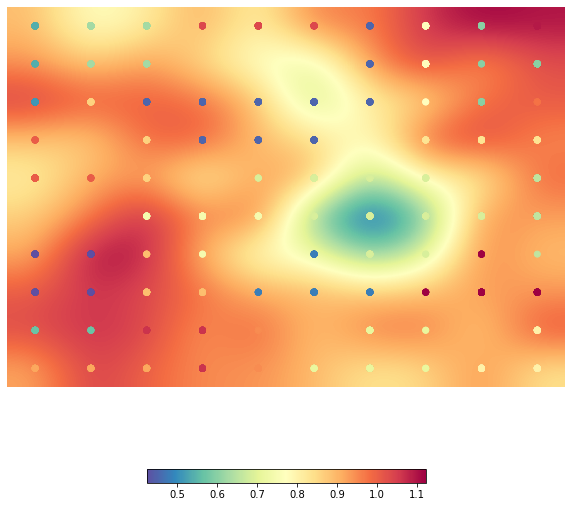

<module 'matplotlib.pyplot' from '/home/sertze/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [66]:
som.view_umatrix(colorbar=True, bestmatches=True, figsize=(10, 10))

In [68]:
print(som.clusters)

[[ 4  7  7 21 21 21  1 12  6 23]
 [ 4  7  7  1 21  1  1 12  6  6]
 [ 3 15  1  1  1  1  1 12  6 19]
 [20 15 15  1  1  1  1 14 14 14]
 [20 20 15 15  9  9  9  9  9  8]
 [20 20 11 11 11  9  9  9  9  8]
 [ 0  0 16 11  2  2  9  9 24  8]
 [ 0  0 16 16  2  2  2 24 24 24]
 [ 5  5 22 22 18  2 10 10 13 13]
 [17 17 17 22 18 10 10 10 13 13]]



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>